In [2]:
import pandas as pd
import numpy as np
from pymoo.factory import get_algorithm, get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize

#%matplotlib qt
from pyreport import PlotUtil
from hermes.postprocessing import get_r_ab_sff
%load_ext autoreload

%autoreload 2

In [3]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "example_data.h5"

row_limit = -1

store_500km = pd.HDFStore(file_path)
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_500km_df = instances_500km_df.sort_index(0)

In [4]:
N_passes = 20

instances_df = instances_500km_df.loc[0:N_passes,:]

In [5]:
from problems.contact_problem import ContactProblem

problem = ContactProblem(instances_df)

method = get_algorithm("ga",
                       pop_size=20,
                       sampling=get_sampling("bin_random"),
                       crossover=get_crossover("bin_hux"),
                       mutation=get_mutation("bin_bitflip"),
                       eliminate_duplicates=True,
                       )

res = minimize(problem,
               method,
               #termination=('n_gen', 40),
               #seed=1,
               #save_history=True
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)
print("Function value: %.2f" % res.F)
print("Constraint violation: %s" % res.CV)

Processes: 0.7739770412445068
Best solution found: [ True  True  True False  True  True False  True  True  True  True  True
 False  True  True  True  True  True  True  True]
Function value: -2037.00
Constraint violation: [0.]


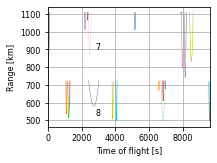

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3.2, 2.4))

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "xelatex",
#     'font.family': 'sans-serif',
#     'text.usetex': False,
#     'pgf.rcfonts': False
# })

lines = [None] * N_passes
for i, pass_df in instances_500km_df.loc[0:N_passes,:].groupby(level=0):
    line, = ax.plot(pass_df.tof.values, pass_df.d.values / 1000., linewidth=0.5)
    lines[i - 1] = line

ax.set_xlabel('Time of flight [s]')
ax.set_ylabel('Range [km]')
ax.grid()
ax.set_xlim((0, instances_500km_df.loc[0:N_passes,:].tof.max()))
plt.tight_layout()

for i in np.where(res.X != 1)[0]:
    lines[i].set_linestyle('dotted')

plt.annotate('7', (2800,900), fontsize=8)
plt.annotate('8', (2800,530), fontsize=8)
PlotUtil.apply_report_formatting()
plt.savefig('D:/git/thesis_report_ae/figures/passes_marked.pdf')

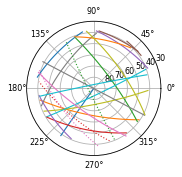

In [7]:
fig = plt.figure(figsize=(2.4, 2.4))
ax = plt.subplot(1,1,1, projection='polar')

def xyz_to_shperical(xyz):
    xy = xyz[:,0]**2 + xyz[:,1]**2
    r = np.sqrt(xy + xyz[:,2]**2)
    theta = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    phi = np.arctan2(xyz[:,1], xyz[:,0])
    return r, theta, phi

lines = [None] * N_passes

for i, pass_df in instances_500km_df.loc[0:N_passes,:].groupby(level=0):
    r_ab_sff = get_r_ab_sff(pass_df) / 1000
    r, theta, phi = xyz_to_shperical(r_ab_sff)
    line, = plt.polar(phi, theta * 180 / np.pi, linewidth=1.125)
    lines[i - 1] = line

plt.yticks(ticks=plt.yticks()[0], labels=["%d" % v for v in 90 - np.array(plt.yticks()[0])])
#plt.grid()
thetaticks = np.arange(0,360,45)
ax.tick_params('x', pad = -0.75)
PlotUtil.apply_report_formatting()

plt.tight_layout(pad=0.5, rect=(0,0,1.05,1.0))

for i in np.where(res.X != 1)[0]:
    lines[i].set_linestyle('dotted')

# plt.subplots_adjust(bottom=0.1)
plt.savefig('D:/git/thesis_report_ae/figures/skyplot_marked.pdf')
